# Forecasting Homeless Shelter Demand for Effective Resource Allocation

### Data Science 3000 Group Project

By: Aaron Serro, Kalan Roye, Jisa Pius, Tina Movahedi


### Step 1: Importing and loading the data


In [2]:
# Importing nessessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


# Loading Dataset
df = pd.read_csv("homelessness_shelter_data.csv")
df.head()

,id,date,shelter_name,city,state,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage,season,notes
0,1,2023-10-05,Sunrise Shelter,Dallas,TX,85,62,23,72.9,19,43,57,Spring,High demand
1,2,2023-08-01,Safe Haven,Dallas,TX,128,117,11,91.4,58,45,55,Summer,No issues reported
2,3,2025-04-27,Second Chance,San Jose,CA,190,144,46,75.8,56,52,48,Summer,Excellent condition
3,4,2024-10-05,Harbor Home,San Jose,CA,115,7,108,6.1,63,48,52,Autumn,Needs maintenance
4,5,2024-09-15,Harbor Home,San Antonio,TX,155,65,90,41.9,21,48,52,Summer,No issues reported


In [3]:
# Summary Statistics

print("shape -", df.shape)
df.describe()

shape - (1000, 14)


,id,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,179.123000,91.874000,87.249000,51.214700,42.037000,54.634000,45.366000
std,288.819436,73.419195,67.068937,65.531224,28.880331,13.768122,8.797468,8.797468
min,1.000000,50.000000,0.000000,0.000000,0.000000,18.000000,40.000000,30.000000
25%,250.750000,115.000000,38.000000,35.000000,26.775000,30.000000,47.000000,38.000000
50%,500.500000,182.000000,76.000000,71.000000,51.850000,42.000000,55.000000,45.000000
75%,750.250000,243.000000,136.000000,128.250000,76.800000,54.000000,62.000000,53.000000
max,1000.000000,300.000000,294.000000,296.000000,100.000000,65.000000,70.000000,60.000000


### Step 2: Cleaning and preprocessing the data


In [4]:
# Handling missing values
df.isna().sum()
df[df.isna().any(axis=1)]
df.replace(["N/A", "na", "?", "missing"], pd.NA, inplace=True)

# Fixing Datatypes
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["id"] = df["id"].astype(str)

# Removing duplicates
df.drop_duplicates(inplace=True)

# Handling outliers
numeric_cols = df.select_dtypes(include=["number"]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"{col}: {len(outliers)} outliers")

total_capacity: 0 outliers
occupied_beds: 1 outliers
available_beds: 10 outliers
occupancy_rate: 0 outliers
average_age: 0 outliers
male_percentage: 0 outliers
female_percentage: 0 outliers


### Step 3: Feature Engineering - adding variables to assist in model training and data analysis


In [5]:
# Feature Engineering
# This variable is for beds available but not filled
df["unmet_demand"] = df["total_capacity"] - df["occupied_beds"]
# column needs to be removed
df["overcapacity_flag"] = (
    df["occupied_beds"] > df["total_capacity"]).astype(int)
df.drop("overcapacity_flag", axis=1, inplace=True)
# This variable is going to be used to see by how much is the shelter overcapacitated, if negative then undercapacitated
df["capacity_gap_ratio"] = (
    df["occupied_beds"] - df["total_capacity"]) / df["total_capacity"]
# ratio of men to women: if >1 then more men, if <1 more women
df["gender_balance_ratio"] = df["male_percentage"] / df["female_percentage"]
# absolute difference between men and women
df["gender_gap"] = abs(df["male_percentage"] - df["female_percentage"])
# Column needs to be removed
df["predominant_gender"] = np.where(
    df["male_percentage"] > df["female_percentage"], "Male", "Female")
df.drop("predominant_gender", axis=1, inplace=True)
# Column needs to be removed
df["utilization_efficiency"] = df["occupied_beds"] / df["total_capacity"]
df.drop("utilization_efficiency", axis=1, inplace=True)
# Percentage of beds that are unsed
df["unused_bed_percent"] = (df["available_beds"] / df["total_capacity"]) * 100

df["pressure_index"] = (df["occupied_beds"] /
                        df["total_capacity"]) * (100 - df["available_beds"])

#When pressure index is high that means empty beds are low and demand/occupancy is high 


df["resource_stress_level"] = pd.cut(
    df["occupancy_rate"],
    bins=[0, 0.6, 0.8, 0.9, 1.1],
    labels=["Low", "Medium", "High", "Critical"]
)

In [6]:
# Show new variables added to dataset
df.describe()

,date,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage,unmet_demand,capacity_gap_ratio,gender_balance_ratio,gender_gap,unused_bed_percent,pressure_index
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-07-16 03:37:26.400000,179.123000,91.874000,87.249000,51.214700,42.037000,54.634000,45.366000,87.249000,-0.487848,1.294896,16.384000,48.784764,21.190160
min,2023-07-30 00:00:00,50.000000,0.000000,0.000000,0.000000,18.000000,40.000000,30.000000,0.000000,-1.000000,0.666667,0.000000,0.000000,-33.110368
25%,2024-01-17 18:00:00,115.000000,38.000000,35.000000,26.775000,30.000000,47.000000,38.000000,35.000000,-0.732440,0.886792,7.500000,23.176789,-5.346363
50%,2024-07-12 00:00:00,182.000000,76.000000,71.000000,51.850000,42.000000,55.000000,45.000000,71.000000,-0.481875,1.222222,14.000000,48.187549,12.112914
75%,2025-01-09 06:00:00,243.000000,136.000000,128.250000,76.800000,54.000000,62.000000,53.000000,128.250000,-0.231768,1.631579,24.000000,73.244048,46.259630
max,2025-07-29 00:00:00,300.000000,294.000000,296.000000,100.000000,65.000000,70.000000,60.000000,296.000000,0.000000,2.333333,40.000000,100.000000,100.000000
std,NaN,73.419195,67.068937,65.531224,28.880331,13.768122,8.797468,8.797468,65.531224,0.288810,0.475697,11.263188,28.880981,34.498163


In [7]:
df["notes"].unique()

array(['High demand', 'No issues reported', 'Excellent condition',
       'Needs maintenance', 'Under inspection', 'Overcrowded',
       'Staff shortage', 'Recently renovated', nan], dtype=object)

In [8]:
# Normalize the notes column, getting rid of all the descriptions based on words and swapping for numbers (easier to classify)
norm_notes_legend = {'High demand': 8, 'Needs maintenance': 7, 'Overcrowded': 6, 'Staff shortage': 5,
                         'Under inspection': 4, 'Recently renovated': 3, 'Excellent condition': 2, 'No issues reported': 1, 'nan':0}
#No need for this function
'''
def normalize_notes(cell_value):
    # Legend to tell which number each note will get
    norm_notes_legend = {'High demand': 8, 'Needs maintenance': 7, 'Overcrowded': 6, 'Staff shortage': 5,
                         'Under inspection': 4, 'Recently renovated': 3, 'Excellent condition': 2, 'No issues reported': 1, 'nan':0}
    for key in norm_notes_legend:
        if cell_value == key:
            return norm_notes_legend[key]
        else:
            return 0


#df['notes'] = df['notes'].apply(normalize_notes)
'''
df['notes_encoded'] = df['notes'].map(norm_notes_legend).fillna(0).astype(int)
df.head()

,id,date,shelter_name,city,state,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,...,season,notes,unmet_demand,capacity_gap_ratio,gender_balance_ratio,gender_gap,unused_bed_percent,pressure_index,resource_stress_level,notes_encoded
0,1,2023-10-05,Sunrise Shelter,Dallas,TX,85,62,23,72.9,19,...,Spring,High demand,23,-0.270588,0.754386,14,27.058824,56.164706,NaN,8
1,2,2023-08-01,Safe Haven,Dallas,TX,128,117,11,91.4,58,...,Summer,No issues reported,11,-0.085938,0.818182,10,8.593750,81.351562,NaN,1
2,3,2025-04-27,Second Chance,San Jose,CA,190,144,46,75.8,56,...,Summer,Excellent condition,46,-0.242105,1.083333,4,24.210526,40.926316,NaN,2
3,4,2024-10-05,Harbor Home,San Jose,CA,115,7,108,6.1,63,...,Autumn,Needs maintenance,108,-0.939130,0.923077,4,93.913043,-0.486957,NaN,7
4,5,2024-09-15,Harbor Home,San Antonio,TX,155,65,90,41.9,21,...,Summer,No issues reported,90,-0.580645,0.923077,4,58.064516,4.193548,NaN,1


In [9]:
df["notes_encoded"].unique()

array([8, 1, 2, 7, 4, 6, 5, 3, 0])

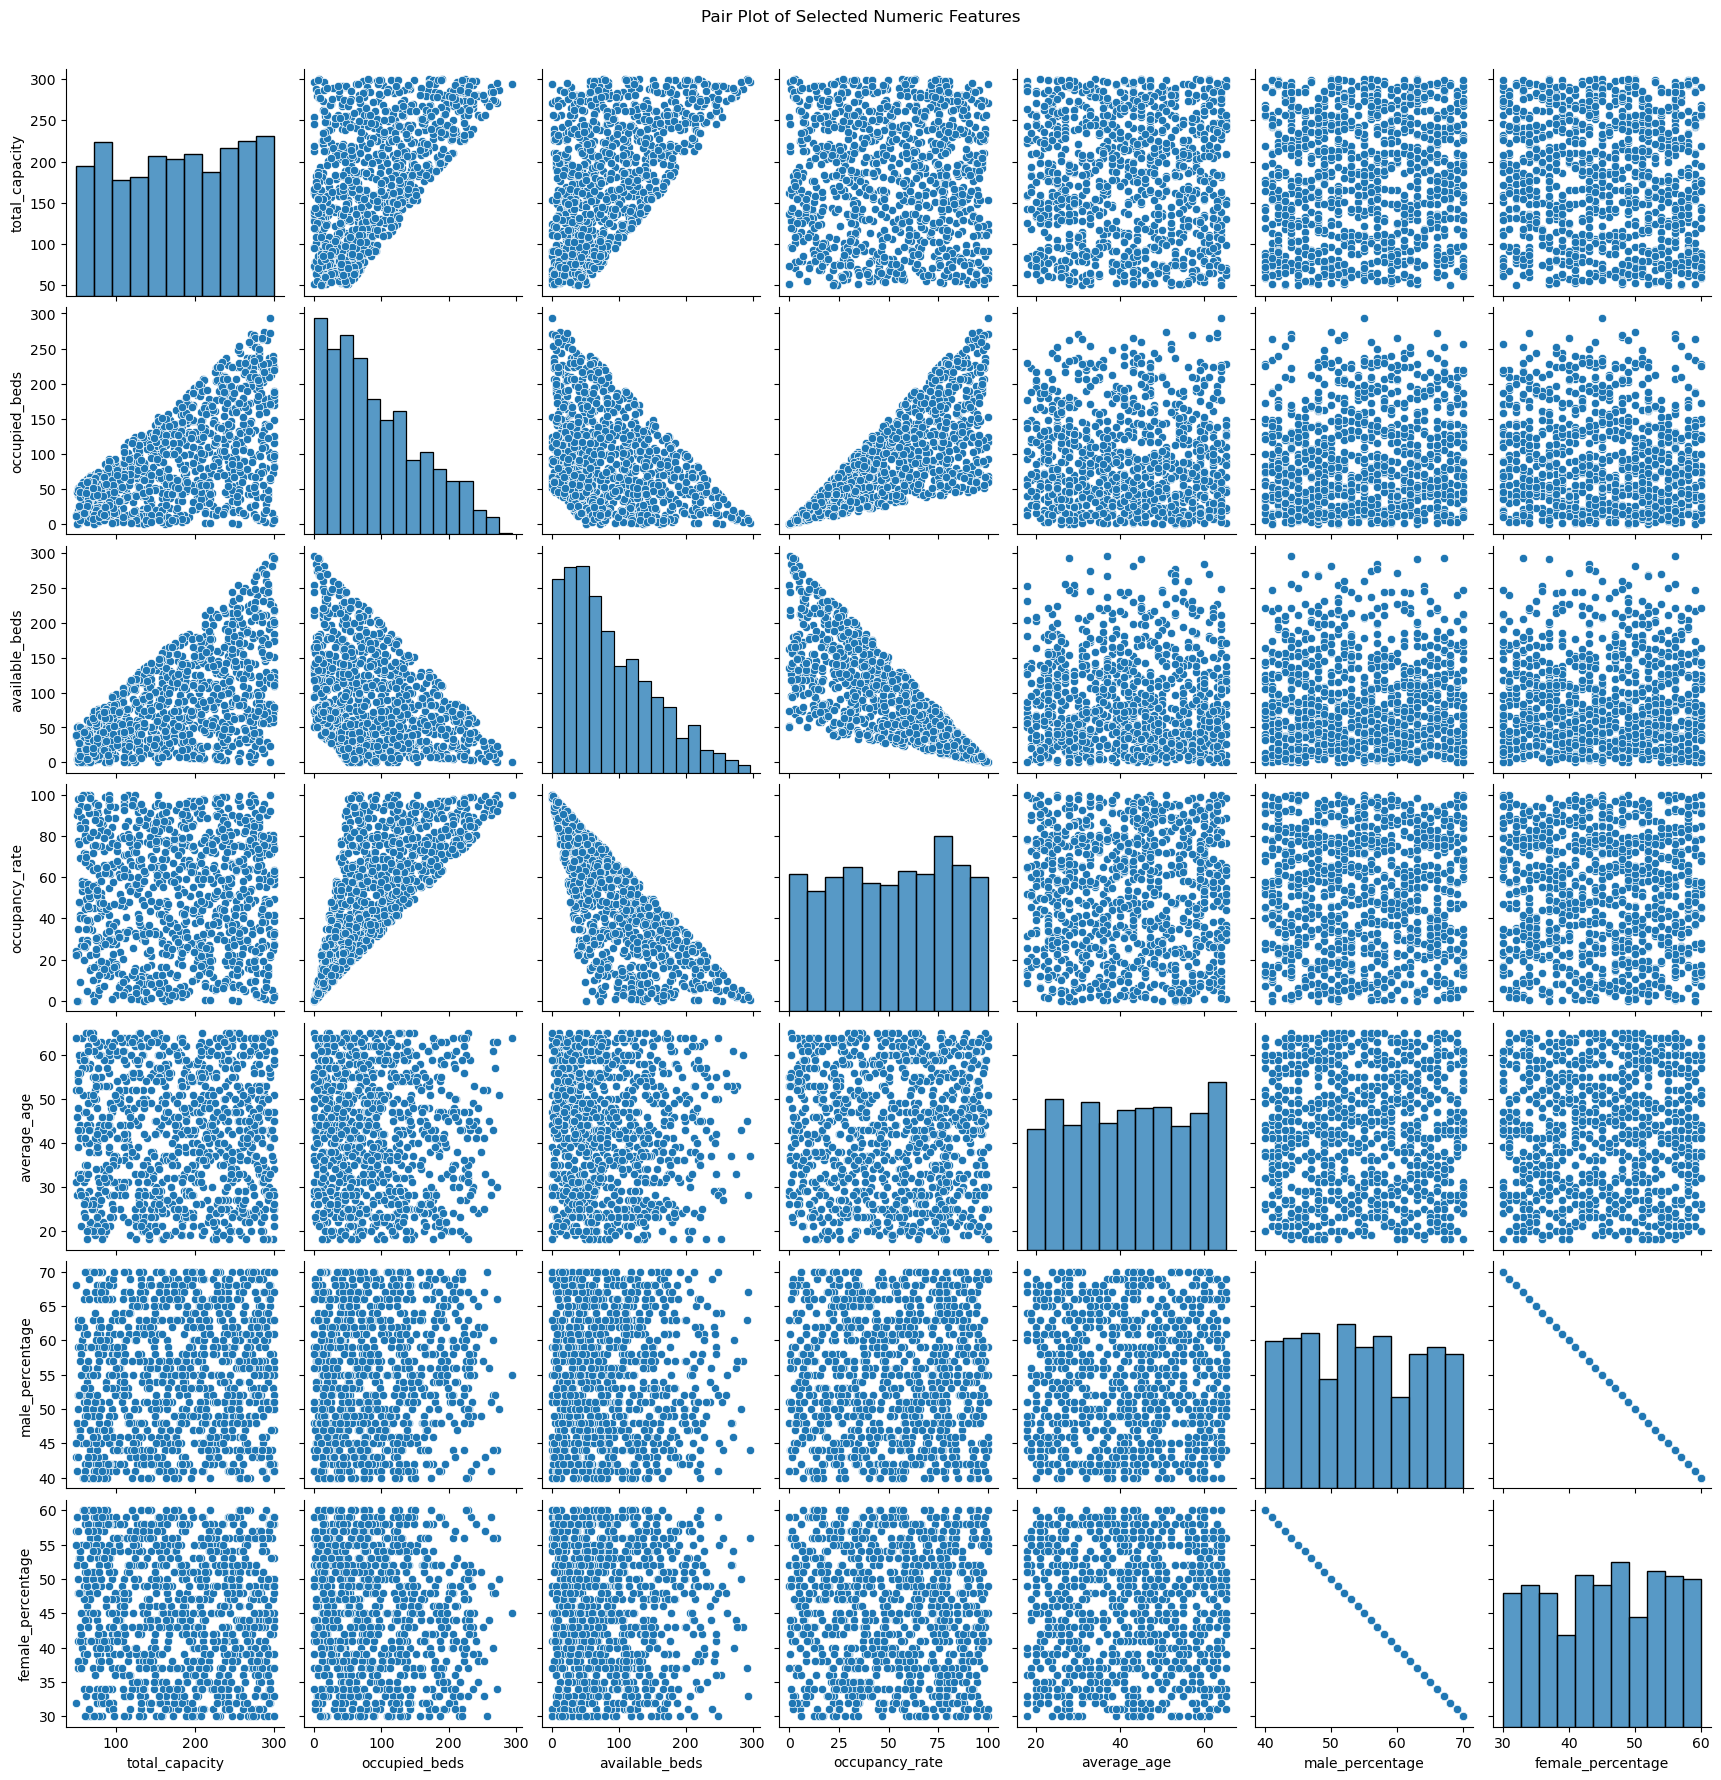

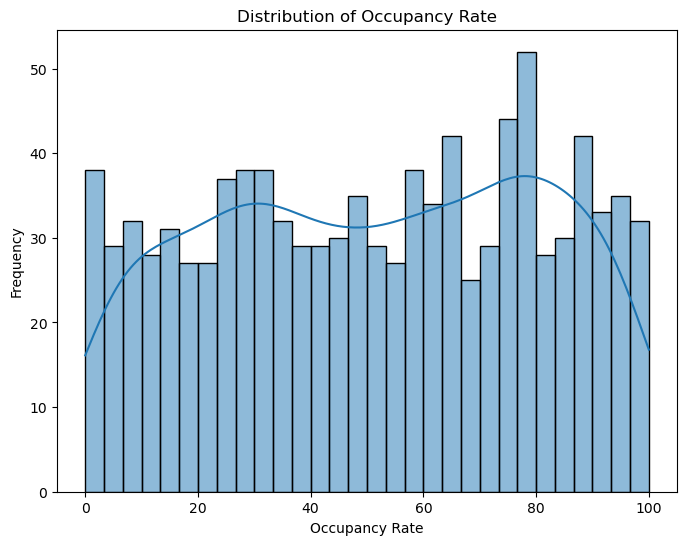

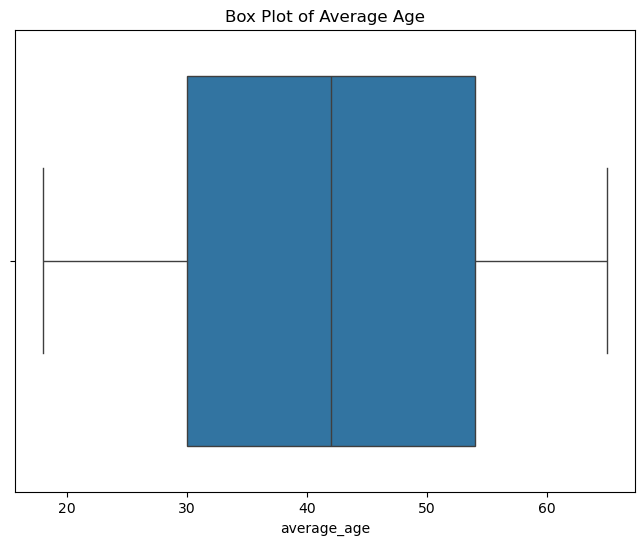

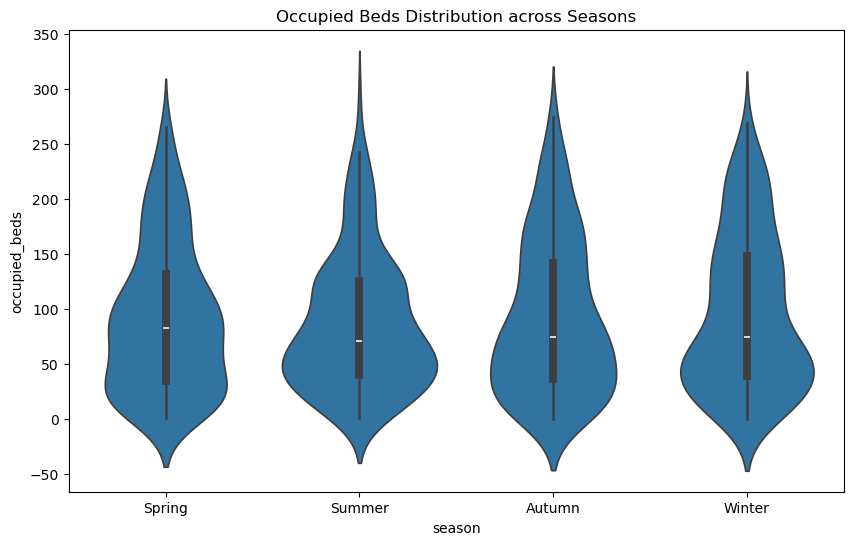

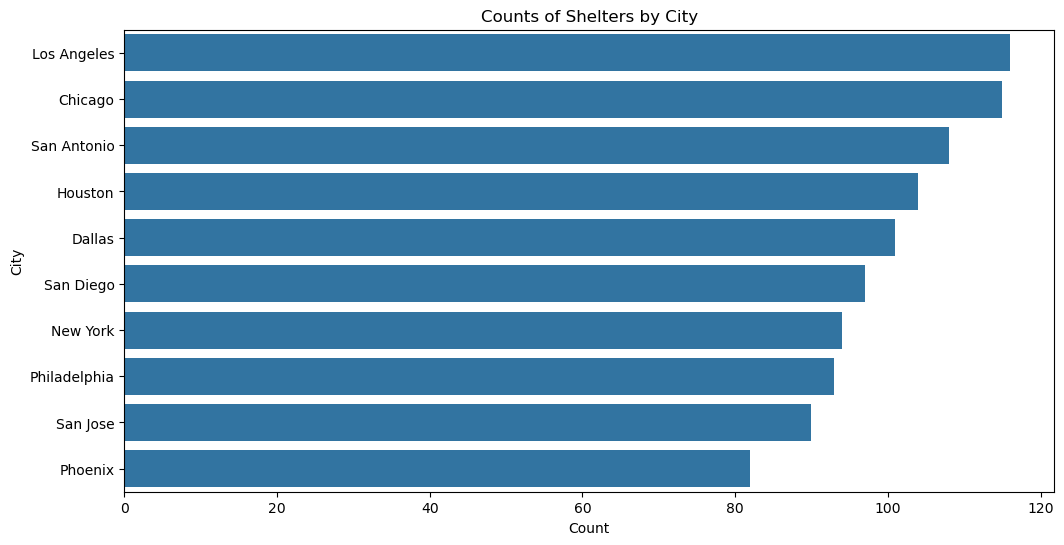

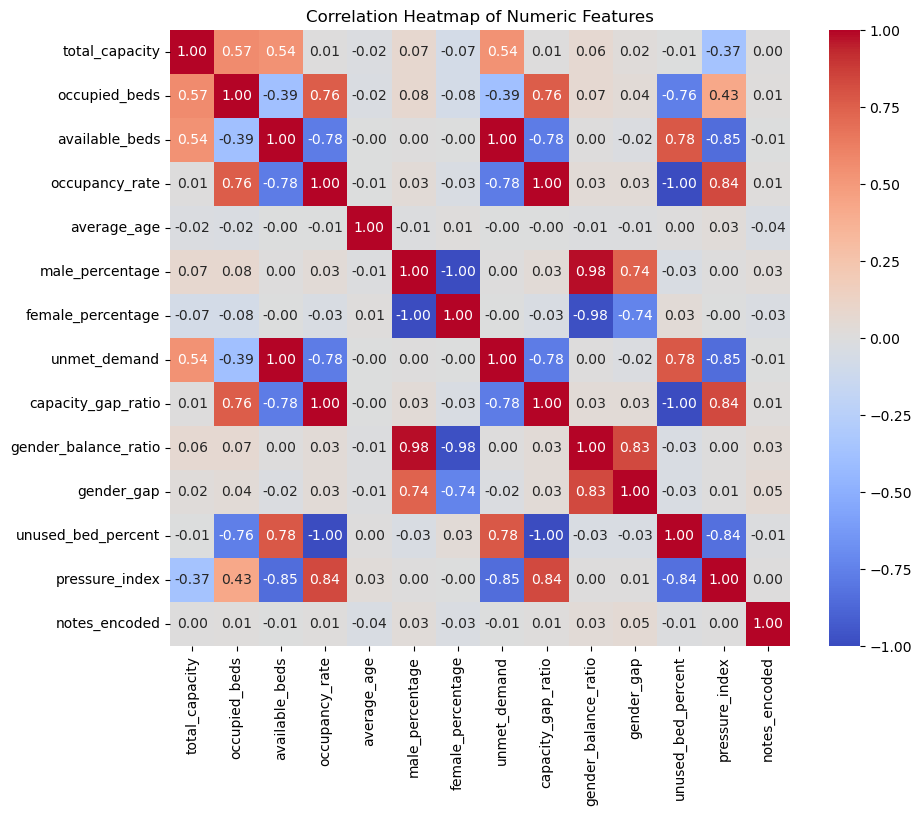

In [10]:
'''Univariate Analysis'''
#Change code not output


numeric_cols = df.select_dtypes(include=["number"]).columns

# Pair Plot: considering a few numeric columns only to avoid overcrowding
numeric_cols = ['total_capacity', 'occupied_beds', 'available_beds',
                'occupancy_rate', 'average_age', 'male_percentage', 'female_percentage']
sns.pairplot(df[numeric_cols])
plt.suptitle('Pair Plot of Selected Numeric Features', y=1.02)
plt.show()

# Histogram for Occupancy Rate
plt.figure(figsize=(8, 6))
sns.histplot(df['occupancy_rate'], kde=True, bins=30)
plt.title('Distribution of Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.show()

# Box Plot for Average Age
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['average_age'])
plt.title('Box Plot of Average Age')
plt.show()

# Violin Plot for Capacity vs Occupied Beds
plt.figure(figsize=(10, 6))
sns.violinplot(x='season', y='occupied_beds', data=df)
plt.title('Occupied Beds Distribution across Seasons')
plt.show()

# Count Plot (Pie Chart alternative) for Shelters by City
plt.figure(figsize=(12, 6))
sns.countplot(y='city', data=df, order=df['city'].value_counts().index)
plt.title('Counts of Shelters by City')
plt.xlabel('Count')
plt.ylabel('City')
plt.show()

# If there are four or more numeric columns, create a correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

In [11]:
#One Hot encoding City variable - Multidimential Array
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
city_encoded = encoder.fit_transform(df[['city']]).toarray()
city_columns = encoder.get_feature_names_out(['city'])
city_df = pd.DataFrame(city_encoded, columns=city_columns)
df = pd.concat([df, city_df], axis=1)


In [12]:
df.columns

Index(['id', 'date', 'shelter_name', 'city', 'state', 'total_capacity',
       'occupied_beds', 'available_beds', 'occupancy_rate', 'average_age',
       'male_percentage', 'female_percentage', 'season', 'notes',
       'unmet_demand', 'capacity_gap_ratio', 'gender_balance_ratio',
       'gender_gap', 'unused_bed_percent', 'pressure_index',
       'resource_stress_level', 'notes_encoded', 'city_Dallas', 'city_Houston',
       'city_Los Angeles', 'city_New York', 'city_Philadelphia',
       'city_Phoenix', 'city_San Antonio', 'city_San Diego', 'city_San Jose'],
      dtype='object')

In [13]:
#One Hot encoding Season variable - Multidimential Array and attachine to DF
season_encoded = encoder.fit_transform(df[['season']]).toarray()
season_columns = encoder.get_feature_names_out(['season'])
season_df = pd.DataFrame(season_encoded, columns=season_columns)
df = pd.concat([df, season_df], axis=1)

In [14]:
df.columns

Index(['id', 'date', 'shelter_name', 'city', 'state', 'total_capacity',
       'occupied_beds', 'available_beds', 'occupancy_rate', 'average_age',
       'male_percentage', 'female_percentage', 'season', 'notes',
       'unmet_demand', 'capacity_gap_ratio', 'gender_balance_ratio',
       'gender_gap', 'unused_bed_percent', 'pressure_index',
       'resource_stress_level', 'notes_encoded', 'city_Dallas', 'city_Houston',
       'city_Los Angeles', 'city_New York', 'city_Philadelphia',
       'city_Phoenix', 'city_San Antonio', 'city_San Diego', 'city_San Jose',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

### Step 3: Exploratory data analysis - seeing what our data looks like visually, and what that means


In [15]:
#Classification Model 
'''
Classification model where the labels of the classifier are the Maintenence status[notes_encoded](1=excellent,2=needs improvement,3...) 
and we would use occupancy rate, unmet_demand and total capacity of the shelter as well as the pressure index to 
determine which label we would give the shelter...as an application of this process we could have a user enter the 
variables of their shelter:total beds, unused beds and the model would spit out a maintence label
'''

'''
Input Features: occupancy_rate, unmet_demand, total_capacity
Target Variable: Maintence_Status - notes_encoded variable
'''
df['city'].unique()

array(['Dallas', 'San Jose', 'San Antonio', 'Phoenix', 'Houston',
       'San Diego', 'Chicago', 'New York', 'Philadelphia', 'Los Angeles'],
      dtype=object)

In [16]:
#Splitting Data for model
'''
The following X and Y variables are being used to predict the maintence Status using 4 different vars as well as city and season
We are going to reframe the probelm and use different X and Y variables to predict occupancy rate 
using numeric features in the original dataset - up to GROUP, change as needed
'''

X = df[['occupancy_rate', 'unmet_demand', 'total_capacity', 
        'average_age'] + 
       [col for col in df.columns if col.startswith('city_') or col.startswith('season_')]]

y = df['notes_encoded'] 




In [17]:
#Splitting the data into 80/20 train test split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [18]:
#Fitting a baseline classifier 
#This line creates a logistic regression model with 1000 iterations and allowing the CPU to use all its cores
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
#This line trains the model using the X and y training Data
clf.fit(X_train, y_train)
#This line outputs the predictions to the y_pred variable using the Test/validation Data
y_pred = clf.predict(X_test)
#printing the accuracy score from the test to prediction variables
print("Accuracy:", accuracy_score(y_test, y_pred))
#prints a classification report 
print(classification_report(y_test, y_pred))

Accuracy: 0.115
              precision    recall  f1-score   support

           0       0.10      0.12      0.11        17
           1       0.14      0.05      0.07        21
           2       0.16      0.14      0.15        21
           3       0.13      0.12      0.13        24
           4       0.14      0.18      0.16        22
           5       0.14      0.14      0.14        22
           6       0.10      0.15      0.12        26
           7       0.11      0.12      0.12        24
           8       0.00      0.00      0.00        23

    accuracy                           0.12       200
   macro avg       0.11      0.11      0.11       200
weighted avg       0.11      0.12      0.11       200



/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
#Thoughts 
'''
Accuracy is as low as random change 11%
In next iteration I will attempt to use Random forest instead of Logistic Regression 
I will also attempt to use SMOTE to augment the data to make the classifier more complex

'''

'\nAccuracy is as low as random change 11%\nIn next iteration I will attempt to use Random forest instead of Logistic Regression \nI will also attempt to use SMOTE to augment the data to make the classifier more complex\n\n'

In [20]:
#For Data Augmentation for Smote Analysis we must see the amount of Datapoint per label
y.value_counts()
#Data is fairly balanced there no need, we will train RandomForest Data on current model 

notes_encoded
6    130
7    120
3    119
8    113
5    112
1    107
4    107
2    105
0     87
Name: count, dtype: int64

In [21]:

'''
the variable rf creates a random forest model with 200 trees 
each tree learns patterns from different subsets of data 
'''
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees in the forest
    max_depth=None,         # trees expand until all leaves are pure or min_samples reached
    random_state=42,        # ensures reproducibility
    n_jobs=-1               # uses all CPU cores for speed
)
rf.fit(X_train, y_train)#Training the model using the training data 



y_pred = rf.predict(X_test)#Predicting on the Test data

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        21
           2       0.17      0.14      0.15        21
           3       0.14      0.12      0.13        24
           4       0.12      0.14      0.12        22
           5       0.20      0.23      0.21        22
           6       0.08      0.08      0.08        26
           7       0.00      0.00      0.00        24
           8       0.14      0.17      0.15        23

    accuracy                           0.10       200
   macro avg       0.09      0.10      0.09       200
weighted avg       0.09      0.10      0.10       200



In [22]:
'''
Thoughts: The accuracy of the model went down, meaning that all trees are disagreeing on the label 
to assign a datapoint...no strong signals between features and maintenance.

'''

rf.fit(X_train, y_train)
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))
'''
The following report shows that the random forest model compleatly fails on test Data 
this is an example of overfitting. To fix the overfitting we must regularize the tree
by adjusting the models parameters 
'''


Train Accuracy: 1.0
Test Accuracy: 0.1


'\nThe following report shows that the random forest model compleatly fails on test Data \nthis is an example of overfitting. To fix the overfitting we must regularize the tree\nby adjusting the models parameters \n'

In [23]:
#The new model is simpler and overfitting is fixed, but the model still compleatly fails on test data
rf = RandomForestClassifier(
    n_estimators=100,       # fewer trees to reduce variance
    max_depth=5,            # limit how deep each tree can grow
    min_samples_split=10,   # need at least 10 samples to split a node
    min_samples_leaf=5,     # each leaf must have at least 5 samples
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))



Train Accuracy: 0.47125
Test Accuracy: 0.09


             Feature  Importance
0     occupancy_rate    0.197369
3        average_age    0.182031
1       unmet_demand    0.180175
2     total_capacity    0.177184
13     season_Spring    0.040597
15     season_Winter    0.032892
11    city_San Diego    0.029534
14     season_Summer    0.029428
9       city_Phoenix    0.020671
10  city_San Antonio    0.019346


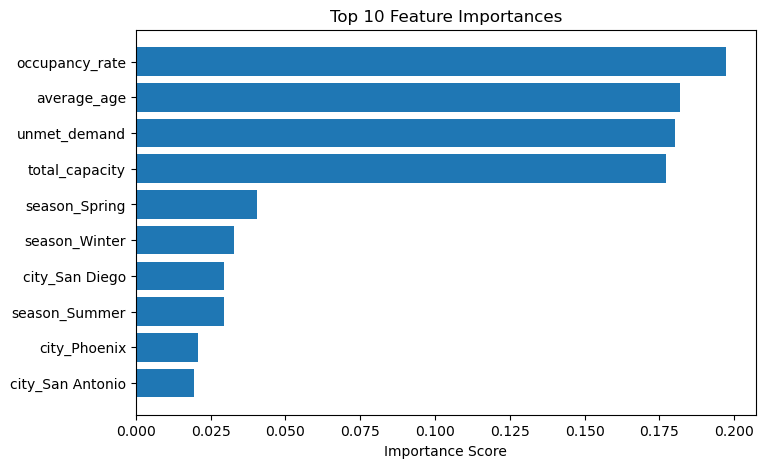

In [24]:
#Feature Importance 

# Get importance scores
importances = rf.feature_importances_

# Match each score with its feature name
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print(feature_importance_df.head(10))  # top 10 features

# Optional bar plot
plt.figure(figsize=(8,5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.show()


In [25]:
#As we can see the model is showing what features matter when predicting 
'''
As we can see the differences around the notes_encoded vars are very small 
therefore logReg and RF perform near random 


'''
df.groupby('notes_encoded')[['occupancy_rate','unmet_demand','average_age']].mean()


,occupancy_rate,unmet_demand,average_age
notes_encoded,,,
0,54.247126,76.816092,43.379310
1,49.536449,91.411215,42.429907
2,51.760952,89.904762,44.790476
3,46.294118,98.546218,40.226891
4,52.213084,79.355140,41.813084
5,53.729464,85.026786,42.553571
6,49.416154,91.315385,39.576923
7,51.283333,87.100000,42.150000
8,53.701770,82.132743,42.389381


In [26]:
#The following is a Linear Regression model to try and predict

X = df[['total_capacity', 'occupied_beds', 'available_beds']]
y = df['occupancy_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
#MAE: Difference between points is around 8 units 

R²: 0.8683858113274142
MAE: 7.946958501456191


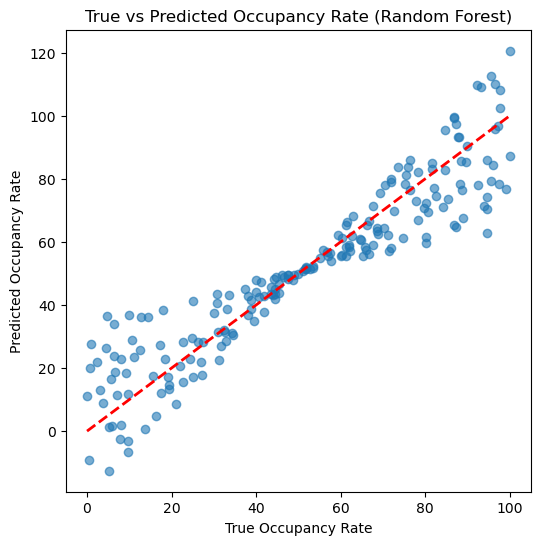

In [27]:
#Regression model 


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("True Occupancy Rate")
plt.ylabel("Predicted Occupancy Rate")
plt.title("True vs Predicted Occupancy Rate (Random Forest)")
plt.show()

In [27]:


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R²: 0.9992408055456308
MAE: 0.5950850000000033


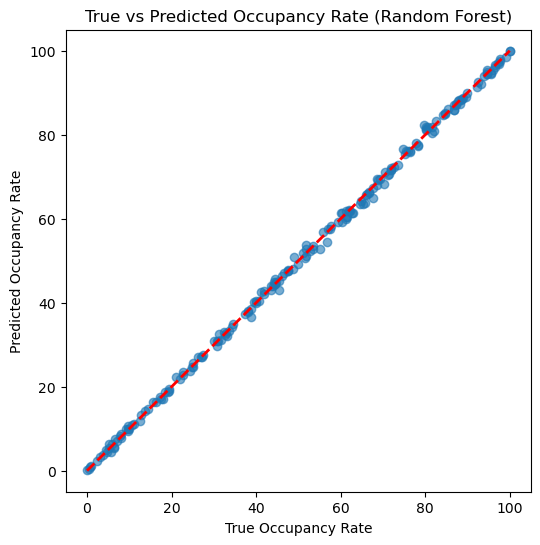

In [28]:
#Regression model 

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("True Occupancy Rate")
plt.ylabel("Predicted Occupancy Rate")
plt.title("True vs Predicted Occupancy Rate (Random Forest)")
plt.show()

In [41]:


# 1. Select features + target
feature_cols = [
    # core capacity + occupancy structure
    "total_capacity",'occupied_beds','available_beds', 'average_age',
    'male_percentage', 'female_percentage'

]

X = df[feature_cols].copy()
y = df["occupancy_rate"].copy()

# 2. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scale features (GPR likes normalized inputs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. Define a kernel
#    Constant * RBF (smooth function) + WhiteKernel (noise term)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e3)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,         # we already model noise via WhiteKernel
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

# 5. Fit model
gpr.fit(X_train_scaled, y_train)

# 6. Predict with uncertainty
y_pred_mean, y_pred_std = gpr.predict(X_test_scaled, return_std=True)

# 7. Evaluate
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print("GPR Test MSE:", mse)
print("GPR Test R^2:", r2)
print("Average predictive std (uncertainty):", np.mean(y_pred_std))



/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR Test MSE: 0.03139807875876142
GPR Test R^2: 0.9999633587126278
Average predictive std (uncertainty): 0.17144181249740345


In [45]:
results = df.loc[X_test.index, :].copy()

results["true_occupancy_rate"] = y_test.values
results["predicted_occupancy_rate"] = y_pred_mean
results["uncertainty"] = y_pred_std

results = results[
    ["shelter_name", "city", "true_occupancy_rate", 
     "predicted_occupancy_rate", "uncertainty"]
]

results.head(20)



,shelter_name,city,true_occupancy_rate,predicted_occupancy_rate,uncertainty
521,Hope House,San Diego,5.2,5.369010,0.190112
737,New Beginnings,New York,94.6,94.515406,0.109033
740,New Beginnings,Chicago,64.8,64.948546,0.100579
660,HomeSafe,San Jose,5.8,5.448248,0.898666
411,Second Chance,Chicago,45.3,45.289109,0.167449
678,Hope House,San Antonio,41.9,41.876630,0.106488
626,Shelter Plus,Los Angeles,87.8,87.738412,0.153491
513,Harbor Home,Philadelphia,65.9,65.977509,0.115922
859,Sunrise Shelter,San Jose,66.7,66.596916,0.104310
136,Shelter Plus,San Antonio,2.4,2.664576,0.128273


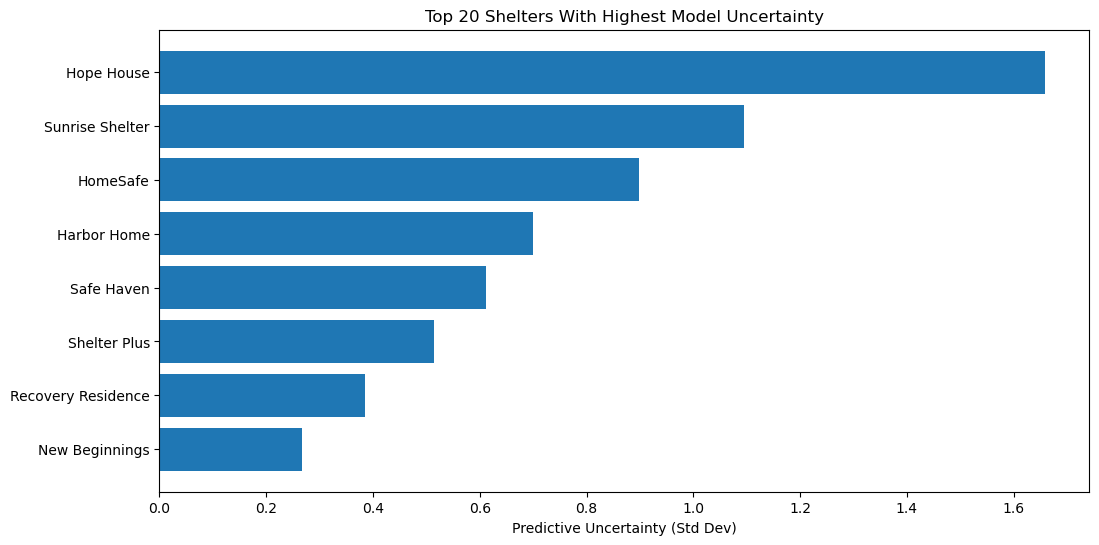

In [47]:
top20 = results.sort_values("uncertainty", ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.barh(top20["shelter_name"], top20["uncertainty"])
plt.xlabel("Predictive Uncertainty (Std Dev)")
plt.title("Top 20 Shelters With Highest Model Uncertainty")
plt.gca().invert_yaxis()
plt.show()




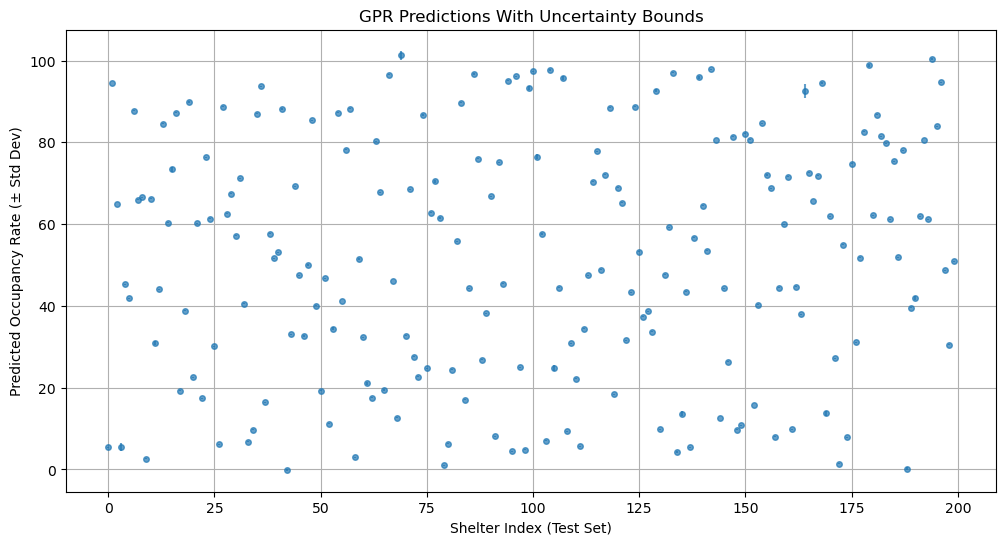

In [48]:
#True vs predicted with uncertainty bands

plt.figure(figsize=(12,6))

plt.errorbar(
    range(len(results)),
    results["predicted_occupancy_rate"],
    yerr=results["uncertainty"],
    fmt='o', markersize=4, alpha=0.7
)

plt.xlabel("Shelter Index (Test Set)")
plt.ylabel("Predicted Occupancy Rate (± Std Dev)")
plt.title("GPR Predictions With Uncertainty Bounds")
plt.grid(True)
plt.show()
